# Analysis of Simulation Data
In this notebook, I want to see how many of the simulated cliques are predicted by the GCN algorithm.

In [ ]:
import pandas as pd
import numpy as np

### basic definitions

In [33]:
def read_implant_positions(file):
    with open(file, 'r') as f:
        subnetworks = []
        disease_genes = []
        for subnet in f.readlines():
            if subnet.startswith('#'):
                continue
            vals = [int(i.strip()) for i in subnet.strip().split(':')[1].strip().split('\t')]
            subnetworks.append(vals)
            disease_genes.append(vals[0])
    return pd.DataFrame(subnetworks), disease_genes

def get_top_n_both(scores, disease_genes, n):
    return scores.head(n)[scores.head(n).index.isin(disease_genes)]

def get_recovered_nodes(scores, subnets):
    idx = []
    for score in scores.index:
        if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
            idx.append(score)
    return scores.loc[idx]

In [ ]:
pagerank_scores = pd.DataFrame.from_csv('../data/simulation/pagerank_scores_sim.txt', sep='\t')
subnets, disease_genes = read_implant_positions('../data/simulation/implant_positions.txt')

In [30]:
pagerank_scores[pagerank_scores.index.isin(subnets)]

,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
0.0,0.0,681,0.000528
1.0,1.0,853,0.000502
2.0,2.0,932,0.000490
3.0,3.0,946,0.000487
4.0,4.0,985,0.000479


In [31]:
get_top_n_both(pagerank_scores, disease_genes, 300)

,Gene_Name,Rank,NetRank_Score
Gene_ID,,,
525.0,525.0,5,0.009391
924.0,924.0,9,0.006083
641.0,641.0,10,0.005996
879.0,879.0,86,0.001710
286.0,286.0,118,0.001427
149.0,149.0,124,0.001402
701.0,701.0,135,0.001356
723.0,723.0,160,0.001266
744.0,744.0,174,0.001183


In [35]:
pr_scores_subnets = get_recovered_nodes(pagerank_scores, subnets)
n = 300
recovered_pr = pr_scores_subnets[pr_scores_subnets.Rank <= n]
print ("Recovered {} implanted nodes within the first {} Ranks".format(recovered_pr.shape[0], n))

Recovered 54 implanted nodes within the first 300 Ranks


# GCN

In [36]:
model_dir = '../data/GCN/training/simulation_cliques_imbalanced/'
gcn_pred = pd.DataFrame.from_csv(model_dir + 'predictions.tsv', sep='\t')
gcn_pred.shape

(1053, 3)

In [37]:
recovered_diseasegenes_gcn = gcn_pred[gcn_pred.index.isin(disease_genes)]
recovered_diseasegenes_gcn[recovered_diseasegenes_gcn.Prob_pos > 0.5].shape

(16, 3)

In [38]:
gcn_idx = []
for score in gcn_pred.index:
    if subnets[subnets.isin([int(score)]).any(axis=1)].shape[0] > 0:
        gcn_idx.append(score)

In [39]:
gcn_pred_for_subnets = gcn_pred.loc[gcn_idx]
gcn_pred_for_subnets.shape

(190, 3)

In [40]:
(gcn_pred.loc[gcn_idx].Prob_pos > .5).shape

(190,)

In [41]:
recovered_gcn = gcn_pred_for_subnets[gcn_pred_for_subnets.Prob_pos > .5]

In [42]:
recovered_gcn.shape, gcn_pred[gcn_pred.Prob_pos > 0.5].shape

((62, 3), (73, 3))

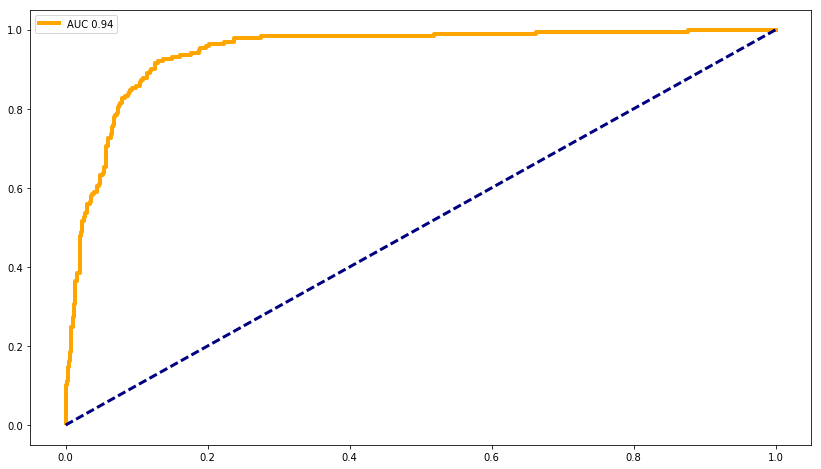

In [43]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
%matplotlib inline
subnet_entries = subnets.values.flatten()
y_true = gcn_pred.index.isin(subnet_entries)
y_score = gcn_pred.Prob_pos
tpr, fpr, _ = roc_curve(y_score=y_score, y_true=y_true)
auc = roc_auc_score(y_score=y_score, y_true=y_true)
fig = plt.figure(figsize=(14, 8))
plt.plot(tpr, fpr, lw=4, color='orange', label='AUC {0:.2f}'.format(auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend()
fig.savefig(model_dir + 'roc_curve.png', dpi=300)

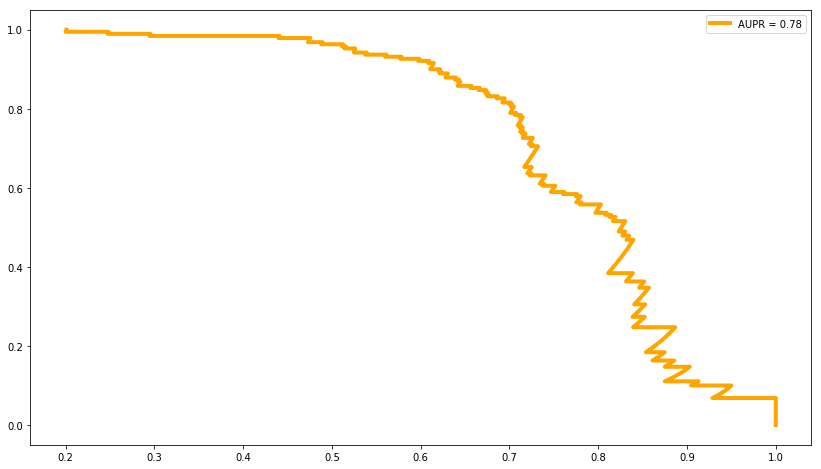

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score
avg_prec = average_precision_score(y_true, y_score)
pr, rc, _ = precision_recall_curve(y_true, y_score)
fig = plt.figure(figsize=(14, 8))
plt.plot(pr, rc, lw=4, color='orange', label='AUPR = {0:.2f}'.format(avg_prec))
plt.legend()
fig.savefig(model_dir + 'prec_recall_curve.png', dpi=300)